## importing the dataset

In [1]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#prevent oom
x_train = x_train[:10000]
y_train = y_train[:10000]

# Normalize images to the range [0, 1]
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# Flatten the images to be vectors
x_train = x_train.reshape(-1, 28 * 28).astype(np.float32)
x_test = x_test.reshape(-1, 28 * 28).astype(np.float32)

# Convert the digit labels to even/odd labels:
# Even -> 0, Odd -> 1
y_train_even_odd = np.array([label % 2 for label in y_train], dtype=np.int32)
y_test_even_odd = np.array([label % 2 for label in y_test], dtype=np.int32)


## building the custom neural network

In [2]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

In [3]:
class CustomDenseLayerTF:
    def __init__(self, num_inputs, num_neurons):
        with tf.device(device):
            self.weights = tf.Variable(tf.random.normal([num_inputs, num_neurons], stddev=0.01, dtype=tf.float32))
            self.Gweights = tf.Variable(tf.random.normal([num_inputs, num_neurons], stddev=0.01, dtype=tf.float32))
            self.bias = tf.Variable(tf.zeros([1, num_neurons], dtype=tf.float32))
            self.prev_output = None  # Store previous output (Zi)

    def forward(self, inputs, delta=0.5):
        self.inputs = inputs
        new_output = tf.matmul(inputs, self.weights) + tf.matmul(inputs, self.Gweights) + self.bias

        if self.prev_output is not None:
            output_diff = tf.abs(new_output - self.prev_output)
            mask = tf.cast(output_diff < delta, dtype=tf.float32)
            self.output = mask * new_output + (1 - mask) * self.prev_output
        else:
            self.output = new_output  # First iteration, no previous output

    def update_weights(self, gradients, learning_rate=0.01):
        """
        Updates the weights of the dense layer
        Params: 
        gradients : gradients of the weights and bias
        learning_rate : learning rate for the optimizer
        """
        self.weights.assign_sub(learning_rate * gradients[0])  # Update weights
        self.Gweights.assign_sub(learning_rate * gradients[1])  # Update weights
        self.bias.assign_sub(learning_rate * gradients[2])      # Update bias

    

In [4]:
#defining the activation functions
class ActivationSigmoidTF:
    def forward(self, inputs):
        """
        perform forwrad pass for the sigmoid activation function
        Params:
        inputs : input from the previous layer
        Returns:    
        output : output of the sigmoid activation function
        """
        self.output = tf.nn.sigmoid(inputs)

class LossBinaryCrossentropyTF:
    def calculate(self, output, y_true):
        """
        Caclulates the binary crossentropy loss
        Params:
        output : output of the model    
        y_true : true labels
        Returns:
        loss : binary crossentropy loss
        """
        output = tf.clip_by_value(output, 1e-7, 1 - 1e-7)  # Avoid log(0)
        return tf.reduce_mean(- (y_true * tf.math.log(output) + (1 - y_true) * tf.math.log(1 - output)))


In [5]:
@tf.function
def train_step(dense_layer, activation, loss_function, X_batch, y_batch, optimizer, delta):
    with tf.GradientTape() as tape:
        # Forward pass with delta constraint
        dense_layer.forward(X_batch, delta=delta)
        activation.forward(dense_layer.output)
        loss = loss_function.calculate(activation.output, y_batch)

    # Compute gradients
    gradients = tape.gradient(loss, [dense_layer.weights, dense_layer.Gweights, dense_layer.bias])

    # Ensure valid gradients
    if gradients is None or any(g is None for g in gradients):
        return None  # If gradient calculation fails, return None

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, [dense_layer.weights, dense_layer.Gweights, dense_layer.bias]))

    # Compute accuracy
    predictions = tf.cast(activation.output > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_batch), dtype=tf.float32))

    return loss, accuracy

In [6]:
def train_custom_nn(X_train, y_train, epochs=5, batch_size=32, learning_rate=0.01, delta=0.5):
    num_samples = X_train.shape[0]

    # Convert input data & labels to TensorFlow tensors
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)

    # Create TensorFlow dataset for efficient training
    dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))
    dataset = dataset.shuffle(num_samples).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Initialize custom model
    with tf.device(device):
        dense_layer = CustomDenseLayerTF(X_train.shape[1], 1)
        activation = ActivationSigmoidTF()
        loss_function = LossBinaryCrossentropyTF()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Training loop
    for epoch in range(epochs):
        total_loss = tf.Variable(0.0, dtype=tf.float32)
        total_accuracy = tf.Variable(0.0, dtype=tf.float32)
        num_batches = tf.Variable(0, dtype=tf.int32)

        # Process data in batches using TensorFlow dataset
        for X_batch, y_batch in dataset:
            result = train_step(dense_layer, activation, loss_function, X_batch, y_batch, optimizer, delta)

            if result is None:
                continue  # Skip this batch if train_step() returned None

            loss, accuracy = result
            total_loss.assign_add(loss)
            total_accuracy.assign_add(accuracy)
            num_batches.assign_add(1)

        # Compute average loss and accuracy per epoch
        avg_loss = total_loss / tf.cast(num_batches, tf.float32)
        avg_accuracy = total_accuracy / tf.cast(num_batches, tf.float32)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss.numpy():.4f}, Accuracy: {avg_accuracy.numpy():.4f}")

    return dense_layer, activation

## training the custom neural network

In [7]:
# Train the custom neural network with a batch size of 64
dense_layer, activation = train_custom_nn(x_train, y_train_even_odd, epochs=2, batch_size=32, delta=0.2)


2025-02-28 21:48:50.105855: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-28 21:48:50.105879: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-28 21:48:50.105883: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-28 21:48:50.105897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-28 21:48:50.105906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-28 21:48:50.421206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-02-28 21:48:52.027715: I t

Epoch 1/2 - Loss: 0.3051, Accuracy: 0.8760
Epoch 2/2 - Loss: 0.2751, Accuracy: 0.8918


2025-02-28 21:48:53.051677: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


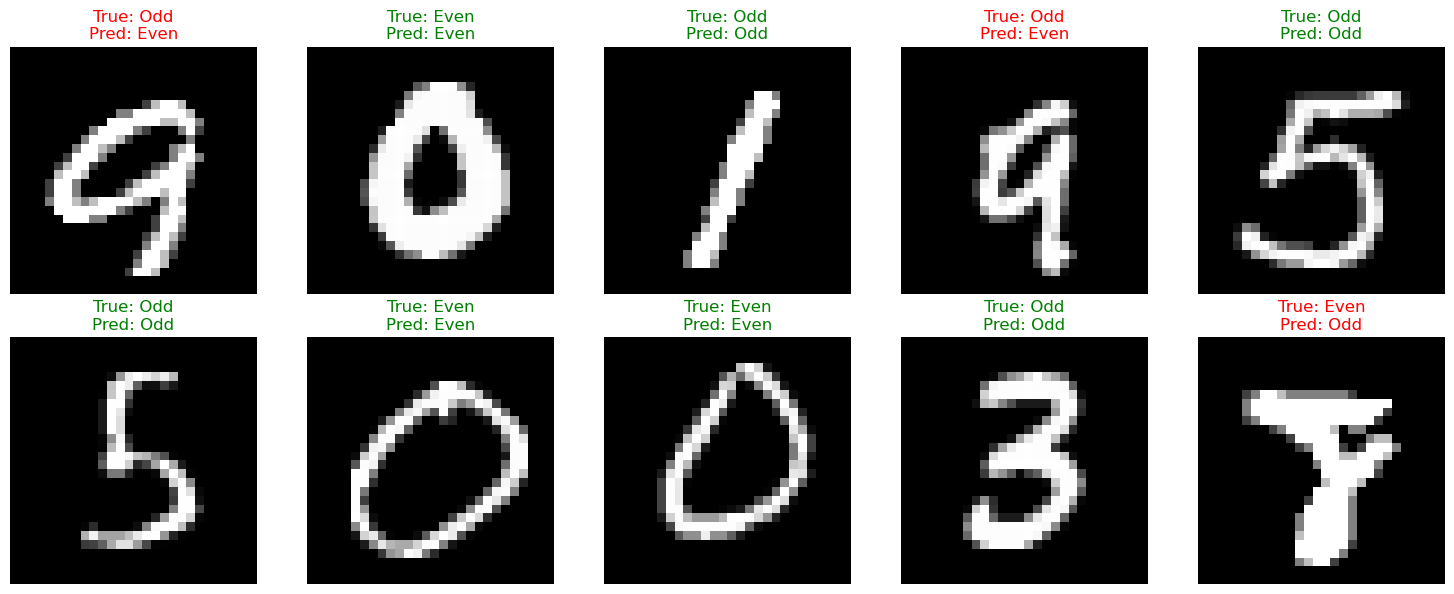


Overall Test Accuracy: 0.8786


In [8]:
# Add this code after your training section
def visualize_predictions(model, X_test, y_test, num_samples=10):
    # Generate random indices
    random_indices = np.random.randint(0, X_test.shape[0], size=num_samples)
    
    # Get random samples
    sample_images = X_test[random_indices]
    true_labels = y_test[random_indices]
    
    # Make predictions
    dense_layer.forward(sample_images, delta=0.5)
    activation.forward(dense_layer.output)
    predictions = tf.cast(activation.output > 0.5, dtype=tf.float32)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for idx, (image, true_label, pred_label) in enumerate(zip(sample_images, true_labels, predictions)):
        # Reshape image back to 28x28
        image = image.reshape(28, 28)
        
        # Display image
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        
        # Create title with true and predicted labels
        title = f'True: {"Odd" if true_label else "Even"}\nPred: {"Odd" if pred_label else "Even"}'
        color = 'green' if true_label == pred_label else 'red'
        axes[idx].set_title(title, color=color)
    
    plt.tight_layout()
    plt.show()

# Test the visualization
# Assuming dense_layer and activation are your trained model components
visualize_predictions(dense_layer, x_test, y_test_even_odd)

# Print overall accuracy
def print_accuracy(model, X_test, y_test):
    dense_layer.forward(X_test, delta=0.5)
    activation.forward(dense_layer.output)
    predictions = tf.cast(activation.output > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_test.reshape(-1, 1)), dtype=tf.float32))
    print(f"\nOverall Test Accuracy: {accuracy.numpy():.4f}")

print_accuracy(dense_layer, x_test, y_test_even_odd)

## training the prebuild tensorflow network


In [9]:
from tensorflow import keras
# ================== TENSORFLOW MODEL (Using GPU) ==================

# Define the equivalent TensorFlow model
with tf.device(device):  # Run on GPU
    model = keras.Sequential([
        keras.layers.Dense(1, activation='sigmoid', input_shape=(28 * 28,))
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    # Train for 5 epochs
    model.fit(x_train, y_train_even_odd, epochs=2, verbose=1, batch_size=32)

    # Evaluate on test data
    loss_tf, accuracy_tf = model.evaluate(x_train, y_train_even_odd, verbose=0)


# print(f"Custom Neural Network Accuracy: {acc:.4f}")
print(f"TensorFlow Neural Network Accuracy: {accuracy_tf:.4f}")

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7859 - loss: 0.4886
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8732 - loss: 0.3149
TensorFlow Neural Network Accuracy: 0.8781


### conclusion
The custom neural network has an accuracy of 89.03 % with batch size = 32, epochs = 2 

The prebuild neural network has an accuracy of 86.26 % with bathc size = 32, epochs =
2 